```
From: https://github.com/ksatola
Version: 0.0.1

TODOs
1. 

```

# Regression Metrics and Evaluation

## Table of Contents

- [Regression Analysis](#intro)
- [Complications](#comp)
- [Metrics](#metr)
    - Coefficient of Determination (R²)
    - Adjusted R-squared and Predicted R-squared
    - Standard Error of the Regression (S) - Adjusted RMSE
    - Comparison of R-squared to the Standard Error of the Regression (S)
    - Mean Absolute Error (MAE)
    - Root Mean Squared Error (RMSE)
    - Mean Squared Logarithmic Error (MSLE)
- [Residuals Plot](#resid)
- [Heteroscedasticity](#hetero)
- [Normal Residuals](#norm_res)
    - Probability Plot (Q-Q Plot)
- [Prediction Error Plot](#pred_err)

---
<a id='intro'></a>

## Regression Analysis
`Regression analysis` models the relationships between a response variable and one or more predictor variables. 
- Use a regression model to understand how changes in the predictor values are associated with changes in the response mean. 
- You can also use regression to make predictions based on the values of the predictors. 

There are a variety of regression methodologies that you choose based on the type of response variable, the type of model that is required to provide an adequate fit to the data, and the estimation method.

---
<a id='comp'></a>

## Real World Complications in the Model Specification Process
The good news is that there are statistical methods that can help you with model specification. Unfortunately, there are a variety of complications that can arise:
- `Your best model is only as good as the data you collect`. Specification of the correct model depends on you measuring the proper variables. In fact, when you omit important variables from the model, the estimates for the variables that you include can be biased. This condition is known as omitted variable bias. If you can’t include a `confounder`, consider including a `proxy variable` to avoid this bias.
- `The sample you collect can be unusual, either by luck or methodology`. False discoveries and false negatives are inevitable when you work with samples.
- `Multicollinearity` occurs when independent variables in a regression equation are correlated. When multicollinearity is present, small changes in the equation can produce dramatic changes in coefficients and p-values. It can also reduce statistical significance in variables that are relevant. For these reasons, multicollinearity makes model selection challenging.
- If you fit many models during the model selection process, you will find variables that appear to be statistically significant, but they are correlated only by chance. This problem occurs because all hypothesis tests have a false discovery rate. This type of `data mining` can make even random data appear to have significant relationships!
- `P-values, adjusted R-squared, predicted R-squared, and Mallows’ Cp can point to different regression equations`. Sometimes there is not a clear answer.
- `Stepwise regression` and `best subsets regression` can help in the early stages of model specification. However, studies show that these tools can get close to the right answer but they usually don’t specify the correct model.

In [2]:
# Connect with underlying Python code
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src') 

In [3]:
from datasets import (
    get_dataset
)

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# To eliminate Yellowbrick warming: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
import matplotlib.font_manager

import seaborn as sns

In [4]:
df = get_dataset('boston_housing')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [5]:
# Missing values?
df.isnull().mean().value_counts()

0.0    14
dtype: int64

In [6]:
y = df[['medv']]
X = df.drop(columns=['medv'])

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=42, n_estimators=1000, n_jobs=-1)
rfr.fit(X_train, y_train.values.ravel())

RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=42)

---
<a id='metr'></a>

## Metrics
The [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) module includes metrics to evaluate regression models. **Metric functions ending in `loss` or `error` should be minimized. Functions ending in `score` should be maximized.**

In [9]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

### Coefficient of Determination (R²)
The `coefficient of determination (r²)` is a common regression metric (goodness-of-fit measure). This value is typically between 0 and 1. It represents the percentage of the variance of the target that the features contribute (the percentage of the variance in the dependent variable that the independent variables explain collectively). R-squared measures the strength of the relationship between your model and the dependent variable on a convenient 0 – 100% scale. Higher values are better, but in general it is difficult to evaluate the model from this metric alone. Does a .7 mean it is a good score? It depends. For a given dataset, .5 might be a good score, while for another dataset, a .9 may be a bad score. In addition, small R-squared values are not always a problem, and high R-squared values are not necessarily good. Typically we use this number in combination with other metrics or visualizations to evaluate a model.

The r² metric is the default metric used during grid search. You can specify other metrics using the `scoring` parameter.

Before assessing numeric measures of goodness-of-fit, like `R-squared`, you should evaluate the `residual plots`. Residual plots can expose a biased model far more effectively than the numeric output by displaying problematic patterns in the residuals. If your model is biased, you cannot trust the results. If your residual plots look good, go ahead and assess your R-squared and other statistics.

`R-squared` evaluates the scatter of the data points around the fitted regression line. It is also called the `coefficient of determination`, or the `coefficient of multiple determination` for multiple regression. For the same data set, higher R-squared values represent smaller differences between the observed data and the fitted values. `R-squared` is the percentage of the dependent variable variation that a linear model explains.

<img src="images/regression_r2.png" style="width: 300px;"/>

R-squared is always between 0 and 100%:

- 0% represents a model that does not explain any of the variation in the response variable around its mean. The mean of the dependent variable predicts the dependent variable as well as the regression model.
- 100% represents a model that explains all of the variation in the response variable around its mean.

Usually, the larger the R2, the better the regression model fits your observations. However, this guideline has important caveats.
- You cannot use R-squared to determine whether the coefficient estimates and predictions are biased, which is why you must assess the residual plots.
- R-squared does not indicate if a regression model provides an adequate fit to your data. A good model can have a low R2 value. On the other hand, a biased model can have a high R2 value!

To visually demonstrate how R-squared values represent the scatter around the regression line, you can plot the fitted values by observed values.

<img src="images/regression_r2_02.png" style="width: 600px;"/>

The R-squared for the regression model on the left is 15%, and for the model on the right it is 85%. When a regression model accounts for more of the variance, the data points are closer to the regression line. In practice, you’ll never see a regression model with an R2 of 100%. In that case, the fitted values equal the data values and, consequently, all of the observations fall exactly on the regression line.

Regression models with low R-squared values can be perfectly good models for several reasons.
- Some fields of study have an inherently greater amount of unexplainable variation. In these areas, your R2 values are bound to be lower. For example, studies that try to explain human behavior generally have R2 values less than 50%. People are just harder to predict than things like physical processes.
- Fortunately, if you have a low R-squared value but the independent variables are statistically significant, you can still draw important conclusions about the relationships between the variables. Statistically significant coefficients continue to represent the mean change in the dependent variable given a one-unit shift in the independent variable. Clearly, being able to draw conclusions like this is vital.
- There is a scenario where small R-squared values can cause problems. If you need to generate predictions that are relatively precise (narrow prediction intervals), a low R2 can be a show stopper.
- High R2 values are not always a problem. In fact, sometimes you can legitimately expect very large values. For example, if you are studying a physical process and have very precise and accurate measurements, it’s possible to obtain valid R-squared values in the high 90s. On the other hand, human behavior inherently has much more unexplainable variability, and this produces R2 values that are usually less than 50%. 90% is way too high in this context!
- You need to use your knowledge of the subject area to determine what R2 values are reasonable. Compare your study to comparable studies to see what values they obtained. 

How high does R-squared need to be for the model produce useful predictions? That depends on the precision that you require and the amount of variation present in your data. A high R2 is necessary for precise predictions, but it is not sufficient by itself.

A regression model with a high R-squared value can have a multitude of problems. You probably expect that a high R2 indicates a good model but examine the graphs below. The fitted line plot models the association between electron mobility and density.

<img src="images/regression_r2_03.png" style="width: 600px;"/>

The data in the fitted line plot follow a very low noise relationship, and the `R-squared` is 98.5%, which seems fantastic. However, the regression line consistently under and over-predicts the data along the curve, which is bias. The `Residuals` versus Fits plot emphasizes this unwanted pattern. An unbiased model has `residuals` that are randomly scattered around zero. `Non-random residual patterns indicate a bad fit despite a high R2`. **Always check your residual plots!** This type of specification bias occurs when your linear model is underspecified. In other words, it is missing significant independent variables, polynomial terms, and interaction terms. `To produce random residuals, try adding terms to the model or fitting a nonlinear model`.

If your R-squared value is too high, consider the following potential explanations:
- **Reason 1: R-squared is a biased estimate** The R-squared value in your regression output has a tendency to be too high. When calculated from a sample, R2 is a biased estimator. In statistics, a biased estimator is one that is systematically higher or lower than the population value. R-squared estimates tend to be greater than the correct population value. This bias causes some researchers to avoid R2 altogether and use adjusted R2 instead. Linear regression methodology gets tripped up by chance correlations that are present in the sample, which causes an inflated R2.
- **Reason 2: Overfitting your model** Overfitting a model is a condition where a statistical model begins to describe the random error in the data rather than the relationships between variables. This problem occurs when the model is too complex. Unfortunately, one of the symptoms of an overfit model is an R-squared value that is too high. While the R2 looks good, there can be serious problems with an overfit model. For one thing, the regression coefficients represent the noise rather than the genuine relationships in the population. Additionally, an overfit regression model is tailor-made to fit the random quirks of one sample and is unlikely to fit the random quirks of another sample. Thus, overfitting a regression model reduces its generalizability outside the original dataset. Adjusted R-squared isn’t designed to detect overfitting, but predicted R-squared can.
- **Reason 3: Data mining and chance correlations** Data mining is the process of fitting many different models, trying many different independent variables, and primarily using statistical significance to build the final model rather than being guided by theory. This process introduces a variety of problems, including misleading coefficients and an inflated R-squared value. For all hypothesis tests, including tests for regression coefficients, there is always the chance of rejecting a null hypothesis that is actually true (Type I error). This error rate equals your significance level, which is often 5%. If you use an automated model building procedure like stepwise or best subsets regression, you might be performing hundreds if not thousands of hypothesis tests on your sample. With this many tests, you will inevitably encounter false positives. If you are guided mainly by statistical significance, you’ll keep these variables in the model. The answer lies in conducting subject-area research before you begin your study. This research helps you reduce the number of models you fit and allows you to compare your results to theory.
- **Reason 4: Trends in Panel (Time Series) Data** If you have panel data and your dependent variable and an independent variable both have trends over time, this can produce inflated R-squared values. Try a time series analysis or include time-related independent variables in your regression model. For instance, try lagging and differencing your variables.
- **Reason 5: Form of a Variable** If you include a different form of the same variable for both the dependent variable and an independent variable, you obtain an artificially inflated R-squared. For example, if the dependent variable is temperature in Celsius and your model contains an independent variable of temperature on a different scale, your R2 is nearly 100%. That’s an obvious example, but there are more subtle forms of it. For instance, you can expect an inflated R2 value if your dependent variable is poverty rate and one of your independent variables is income. Poverty rate is defined by income.

How serious is this problem? The answer lies in conducting subject-area research before you begin your study. This research helps you reduce the number of models you fit and allows you to compare your results to theory.

A variety of other circumstances can artificially inflate your R2. These reasons include overfitting the model and data mining. Either of these can produce a model that looks like it provides an excellent fit to the data but in reality the results can be entirely deceptive. An overfit model is one where the model fits the random quirks of the sample. Data mining can take advantage of chance correlations. In either case, you can obtain a model with a high R2 even for entirely random data!

At first glance, `R-squared` seems like an easy to understand statistic that indicates how well a regression model fits a data set. However, it doesn’t tell us the entire story. To get the full picture, you must consider R2 values in combination with residual plots, other statistics, and in-depth knowledge of the subject area.

The `.score` method calculates this for regression models.

#### R-squared Is Not Valid for Nonlinear Regression
Nonlinear regression is an extremely flexible analysis that can fit most any curve that is present in your data. R-squared seems like a very intuitive way to assess the goodness-of-fit for a regression model. Unfortunately, the two just don’t go together. `R-squared is invalid for nonlinear regression`.

R-squared is the following proportion:

<img src="images/regression_r2.png" style="width: 300px;"/>

Furthermore, the variances always add up in a particular way:
```
Explained variance + Error variance = Total variance.
```
This arrangement produces an R-squared that is always between 0 – 100%.

For linear models, this works out as you expect. However, this math works out correctly only for linear regression models. In nonlinear regression, these underlying assumptions are incorrect. Explained variance + Error variance DO NOT add up to the total variance! The result is that R-squared isn’t necessarily between 0 and 100%. There are other problems with it as well. This problem completely undermines R-squared in the context of nonlinear regression. Keep in mind that I’m referring specifically to nonlinear models. R-squared is valid for linear models that use polynomials to model curvature. 

The general mathematic framework for R-squared doesn’t work out correctly if the regression model is not linear. Despite this issue, most statistical software still calculates R-squared for nonlinear models. This questionable practice can cause problems for you. Let’s see the ramifications!

Spiess and Neumeyer (Spiess, Andrej-Nikolai, Natalie Neumeyer. An evaluation of R2 as an inadequate measure for nonlinear models in pharmacological and biochemical research: a Monte Carlo approach. BMC Pharmacology. 2010; 10: 6.) performed a simulation study to look at the effect of using R-squared to assess the goodness-of-fit for models that are not linear. Their study ran thousands of simulations and found that R-squared leads you to draw false conclusions about which nonlinear models are best.

If you use R-squared for nonlinear models, their study indicates you will experience the following problems:

- R-squared is consistently high for both excellent and appalling models.
- R-squared will not rise for better models all of the time.
- If you use R-squared to pick the best model, it leads to the proper model only 28-43% of the time.

If you take all of these together, R-squared can’t differentiate between good and bad nonlinear models. It just doesn’t work. The authors go on to disparage the continuing practice of statistical software to calculate R-squared for nonlinear regression:
```
In the field of biochemical and pharmacological literature there is a reasonably high occurrence in the use of R2 as the basis of arguing against or in favor of a certain model. . . . Additionally, almost all of the commercially available statistical software packages calculate R2 values for nonlinear fits, which is bound to unintentionally corroborate its frequent use. . . . As a result from this work, we would like to advocate that R2 should not be reported or demanded in pharmacological and biochemical literature when discussing nonlinear data analysis.
```
If your statistical software calculates R-squared for nonlinear models, don’t trust it!

In [10]:
from sklearn import metrics

rfr.score(X_test, y_test)

0.8763367508673342

In [11]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
metrics.r2_score(y_test, rfr.predict(X_test))

0.8763367508673343

There is also an explained variance metric (`explained_variance` in grid search). If the mean of the residuals (errors in predictions) is 0 (in ordinary least squares (OLS) models), then the variance explained is the same as the coefficient of determination.

In [12]:
metrics.explained_variance_score(y_test, rfr.predict(X_test))

0.8765301856464149

### Adjusted R-squared and Predicted R-squared
Typically, you want to select models that have larger `adjusted and predicted R-squared` values. These statistics can help you avoid the fundamental problem with `regular R-squared` - it always increases when you add an independent variable. This property tempts you into specifying a model that is too complex, which can produce misleading results.

- **Adjusted R-squared** increases only when a new variable improves the model by more than chance. Low-quality variables can cause it to decrease.
- **Predicted R-squared** is a cross-validation method that can also decrease. Cross-validation partitions your data to determine whether the model is generalizable outside of your dataset.

### Standard Error of the Regression (S) - Adjusted RMSE
The `standard error of the regression (S)`, also known as the `standard error of the estimate`, represents the average distance that the observed values fall from the regression line. Conveniently, it tells you how wrong the regression model is on average using the units of the response variable. Smaller values are better because it indicates that the observations are closer to the fitted line.

Unlike `R-squared`, you can use the `standard error of the regression` to assess the precision of the predictions. `Approximately 95% of the observations should fall within plus/minus 2*standard error of the regression from the regression line, which is also a quick approximation of a 95% prediction interval`. If want to use a regression model to make predictions, assessing the standard error of the regression might be more important than assessing R-squared.

`S` is the square root of the adjusted mean square error. The adjustment is the same as adjusted R-squared, which is based on the number of predictors. It’s valid to use in nonlinear regression.

<img src="images/regression_s2.png" style="width: 300px;"/>

Where `n` is the number of observations and `p` is the number of coefficients in the model not counting the constant.

#### Comparison of R-squared to the Standard Error of the Regression (S)
Both of these measures give you a numeric assessment of how well a model fits the sample data. However, there are differences between the two statistics.

<img src="images/regression_s.png" style="width: 300px;"/>

- The `standard error of the regression` provides **the absolute measure** of the typical distance that the data points fall from the regression line. S is in the units of the dependent variable.
- `R-squared` provides the relative **measure of the percentage** of the dependent variable variance that the model explains. R-squared can range from 0 to 100%. R-squared doesn’t have any units, and it feels more ambiguous than S. If all we know is that R-squared is XX%, we don’t know how wrong the model is on average. You do need a high R-squared to produce precise predictions, but you don’t know how high it must be exactly. It’s impossible to use R-squared to evaluate the precision of the predictions.

An analogy makes the difference very clear. Suppose we’re talking about how fast a car is traveling.

`R-squared` is equivalent to saying that the car went 80% faster. That sounds a lot faster! However, it makes a huge difference whether the initial speed was 20 MPH or 90 MPH. The increased velocity based on the percentage can be either 16 MPH or 72 MPH, respectively. One is lame, and the other is very impressive. If you need to know exactly how much faster, the relative measure just isn’t going to tell you.

The `standard error of the regression` is equivalent to telling you directly how many MPH faster the car is traveling. The car went 72 MPH faster. Now that’s impressive!

The `standard error of the regression` has several advantages. 
- S tells you straight up how precise the model’s predictions are using the units of the dependent variable. This statistic indicates how far the data points are from the regression line on average. You want lower values of S because it signifies that the distances between the data points and the fitted values are smaller. 
- S is also valid for both linear and nonlinear regression models. This fact is convenient if you need to compare the fit between both types of models.

For `R-squared`, you want the regression model to explain higher percentages of the variance. 
- Higher R-squared values indicate that the data points are closer to the fitted values. While higher R-squared values are good, they don’t tell you how far the data points are from the regression line. 
- Additionally, R-squared is valid for only linear models. `You can’t use R-squared to compare a linear model to a nonlinear model`.

Note: Linear models can use polynomials to model curvature. I’m using the term linear to refer to models that are linear in the parameters.

### Mean Absolute Error (MAE)
`Mean absolute error` (`neg_mean_absolute_error` when used in grid search) expresses the average absolute model prediction error. A perfect model would score 0, but this metric has no upper bounds, unlike the coefficient of determination. However, since **it is in units of the target, it is more interpretable**. If you want to ignore outliers, this is a good metric to use.

This measure cannot indicate how bad a model is, but can be used to compare two models. If you have two models, the model with a lower score is better.

This number tells us that the average error is about two above or below the real value.

In [13]:
metrics.mean_absolute_error(y_test, rfr.predict(X_test))

2.072138815789479

### Root Mean Squared Error (RMSE)
`Root mean squared error` (`neg_mean_squared_error` in grid search) also measures model error in terms of the target. However, because it averages the square of errors before taking the square root, **it penalizes large errors**. If you want to penalize large errors, this is a good metric to use. For example, if being off by eight is more than two times worse than being off by four.

As with `mean absolute error`, this measure cannot indicate how bad a model is, but can be used to compare two models. If you assume that errors are normally distributed, this is a good choice.

The result tells us if we square the errors and average them, the result will be around 9.5

In [14]:
metrics.mean_squared_error(y_test, rfr.predict(X_test))

9.214531500855275

### Mean Squared Logarithmic Error (MSLE)
The `mean squared logarithmic error` (in grid search, `neg_mean_squared_log_error`) **penalizes underprediction more than overprediction**. If you have targets that experience exponential growth (population, stock, etc.), this is a good metric.

If you take the log of the error and then square it, the average of these results will be 0.021.

In [15]:
metrics.mean_squared_log_error(y_test, rfr.predict(X_test))

0.02122917655324258

---
<a id='resid'></a>

## Residuals Plot
In statistical models, a `residual` is the difference between the observed value and the mean value that the model predicts for that observation. Residual values are especially useful in regression and ANOVA procedures because they indicate the extent to which a model accounts for the variation in the observed data.

Good models (with appropriate `R2 scores`) will exhibit `homoscedasticity`. This means the variance is the same for all values of targets regardless of the input. Plotted, this looks like randomly distributed values in a residuals plot. **If there are patterns, the model or the data are problematic**. You want these plots to display random residuals (no patterns) that are uncorrelated and uniform. Generally speaking, if you see patterns in the residuals, your model has a problem, and you might not be able to trust the results.

Before assessing numeric measures of goodness-of-fit, like `R-squared`, you should evaluate the `residual plots`. Residual plots can expose a biased model far more effectively than the numeric output by displaying problematic patterns in the residuals. If your model is biased, you cannot trust the results. If your residual plots look good, go ahead and assess your R-squared and other statistics.

**Residuals plots also show outliers**, which can have a big impact on model fitting.

Use residual plots to check the assumptions of an OLS linear regression model. If you violate the assumptions, you risk producing results that you can’t trust. Residual plots display the residual values on the y-axis and fitted values, or another variable, on the x-axis. After you fit a regression model, it is crucial to check the residual plots. If your plots display unwanted patterns, you can’t trust the regression coefficients and other numeric results.

There are two fundamental parts to regression models, the deterministic and random components. If your model is not random where it supposed to be random, it has problems, and this is where residual plots come in. The essential parts of a regression model:
```
Dependent Variable = (Constant + Independent Variables) + Error

Or:

Dependent Variable = Deterministic + Stochastic
```

### Deterministic Component
The deterministic component is the portion of the variation in the dependent variable that the independent variables explain. In other words, the mean of the dependent variable is a function of the independent variables. In a regression model, `all of the explanatory power should reside here`.

### Stochastic Error
`Stochastic` just means unpredictable. In statistics, the error is the difference between the expected value and the observed value. Let’s put these terms together - `the gap between the expected and observed values must not be predictable`. Or, `no explanatory power should be in the error`. If you can use the error to make predictions about the response, your model has a problem. This issue is where residual plots play a role.

The theory here is that the deterministic component of a regression model does such a great job of explaining the dependent variable that it leaves only the intrinsically inexplicable portion of your study area for the error. If you can identify non-randomness in the error term, your independent variables are not explaining everything that they can. It just means that you should not be able to see patterns in the residual plots!

### How to Check Residual Plots
When looking at residual plots, you simply want to determine whether the residuals are consistent with random error. I’ll use an analogy of rolling a die. You shouldn’t be able to use one roll to predict the outcome of the next roll because it is supposed to be random. So, if you record a series of tosses, you should see only random results. If you start to see patterns, you know something is wrong with your model of how the die works. You think it’s random, but it’s not. If you were a gambler, you’d use this information to adjust how you play to match the actual die outcomes better.

You can apply this idea to regression models too. If you look at a series of errors, it should look random. If there are patterns in the errors, this means that you can use one error to predict another. As with the die analogy, if there are patterns in the residuals, you need to adjust your model. But, don’t fret, this just means that you can improve the fit of the model by moving this predictability over to the deterministic side of things (i.e., your independent variables).

How do you determine whether the residuals are random in regression analysis? It’s pretty simple, just check that they are `randomly scattered around zero for the entire range of fitted values`. When the residuals center on zero, they indicate that the model’s predictions are correct on average rather than systematically too high or low. `Regression also assumes that the residuals follow a normal distribution and that the degree of scattering is the same for all fitted values`.

Residuals should look like this:

<img src="images/regression_resid1.png" style="width: 600px;"/>

### How to Fix Problematic Residual Plots
The residual plot below clearly has a pattern:

<img src="images/regression_resid2.png" style="width: 600px;"/>

If you know the fitted value, you can use it to predict the residual. For instance, fitted values near 5 and 10 tend to have positive residuals while fitted values near 7 tend to have negative values. If they were truly random, you wouldn’t be able to make these predictions.

This residual plot indicates that the independent variables do not capture the entire deterministic component. Unfortunately, some of the explanatory information has leaked over to the supposedly random error. There are a variety of reasons why a model can have this problem. The possibilities include a missing:
- Independent variable.
- Polynomial term to model a curve.
- Interaction term.

To fix the problem, you need to identify the missing information, variable, or higher-order term and include it in the model. After you correct the problem and refit the model, the residuals should look nice and random! It might require subject-area knowledge and research to do this. The solution is very particular to your research.

### Other Potential Problems
There are several other ways that explanatory information might make its way into your residuals:
- **Another variable must not be correlated with the residuals**. If a variable is related to the residuals, that variable can predict the residuals, which is a no-no. Try including this variable in the model. To identify this correlation, graph the residuals by other variables. This problem relates to confounding variables and causes omitted variable bias.
- **Neighboring residuals must not be correlated**. If adjacent residuals are correlated, one residual can predict the next residual. In statistics, this is known as `autocorrelation`. This correlation represents explanatory information that the independent variables do not describe. Models that use time-series data are susceptible to this problem. To resolve this issue, try adding an independent variable that contains the pertinent time information. Use the `Durbin-Watson test to assess autocorrelation`.
- **Residuals must have a constant variance**. `Heteroscedasticity` refers to cases where the residuals have a non-constant variance.

When your linear regression model satisfies the OLS assumptions, the procedure generates unbiased coefficient estimates that tend to be relatively close to the true population values (minimum variance). In fact, the Gauss-Markov theorem states that OLS produces estimates that are better than estimates from all other linear model estimation methods when the assumptions hold true.

In [16]:
X_train

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21
116,0.13158,0.0,10.01,0,0.547,6.176,72.5,2.7301,6,432,17.8,393.30,12.04
45,0.17142,0.0,6.91,0,0.448,5.682,33.8,5.1004,3,233,17.9,396.90,10.21
16,1.05393,0.0,8.14,0,0.538,5.935,29.3,4.4986,4,307,21.0,386.85,6.58
468,15.57570,0.0,18.10,0,0.580,5.926,71.0,2.9084,24,666,20.2,368.74,18.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.17120,0.0,8.56,0,0.520,5.836,91.9,2.2110,5,384,20.9,395.67,18.66
270,0.29916,20.0,6.96,0,0.464,5.856,42.1,4.4290,3,223,18.6,388.65,13.00
348,0.01501,80.0,2.01,0,0.435,6.635,29.7,8.3440,4,280,17.0,390.94,5.99
435,11.16040,0.0,18.10,0,0.740,6.629,94.6,2.1247,24,666,20.2,109.85,23.27


In [17]:
y_train

,medv
5,28.7
116,21.2
45,19.3
16,23.1
468,19.1
...,...
106,19.5
270,21.1
348,24.5
435,13.4


In [18]:
from yellowbrick.regressor import ResidualsPlot

def show_residuals_plot(model, X_train, y_train, X_test, y_test):
    
    print(type(X_train))
    print(X_train.shape)
    print(y_train.shape)

    fig, ax = plt.subplots(figsize=(12, 8))
    rpv = ResidualsPlot(model)
    rpv.fit(X_train, y_train)
    rpv.score(X_test, y_test)
    rpv.poof()
    #fig.savefig("images/regression_metrics_residuals_plot.png", dpi=300)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


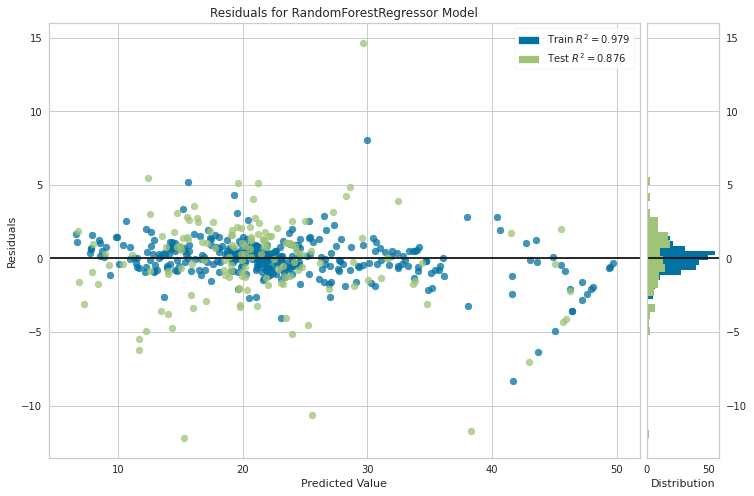

In [17]:
from yellowbrick.regressor import ResidualsPlot

fig, ax = plt.subplots(figsize=(12, 8))
rpv = ResidualsPlot(rfr)
rpv.fit(X_train, y_train.values.ravel())
rpv.score(X_test, y_test.values.ravel())
rpv.poof()
fig.savefig("images/regression_metrics_residuals_plot.png", dpi=300)

---
<a id='hetero'></a>

## Heteroscedasticity

`Heteroscedasticity` means unequal scatter. In regression analysis, we talk about heteroscedasticity in the context of the residuals or error term. Specifically, heteroscedasticity is a systematic change in the spread of the residuals over the range of measured values. Heteroscedasticity is a problem because ordinary least squares (OLS) regression assumes that all residuals are drawn from a population that has a constant variance (`homoscedasticity`).

`To satisfy the regression assumptions and be able to trust the results, the residuals should have a constant variance.` 

Heteroscedasticity produces a distinctive fan or cone shape in residual plots. To check for heteroscedasticity, you need to assess the residuals by fitted value plots specifically. Typically, the telltale pattern for heteroscedasticity is that as the fitted values increases, the variance of the residuals also increases.

You can see an example of this cone shaped pattern in the residuals by fitted value plot below. Note how the vertical range of the residuals increases as the fitted values increases. 

<img src="images/regression_heteroscedasticity1.png" style="width: 600px;"/>

### What Causes Heteroscedasticity?
Heteroscedasticity, also spelled heteroskedasticity, occurs more often in datasets that have a large range between the largest and smallest observed values. While there are numerous reasons why heteroscedasticity can exist, a common explanation is that the error variance changes proportionally with a factor. This factor might be a variable in the model.

In some cases, the variance increases proportionally with this factor but remains constant as a percentage. For instance, a 10% change in a number such as 100 is much smaller than a 10% change in a large number such as 100,000. In this scenario, you expect to see larger residuals associated with higher values. That’s why you need to be careful when working with wide ranges of values!

Because large ranges are associated with this problem, some types of models are more prone to heteroscedasticity.

### Pure versus impure heteroscedasticity
You can categorize heteroscedasticity into two general types.

- **Pure heteroscedasticity** refers to cases where you specify the correct model and yet you observe non-constant variance in the residual plots.
- **Impure heteroscedasticity** refers to cases where you incorrectly specify the model, and that causes the non-constant variance. When you leave an important variable out of a model, the omitted effect is absorbed into the error term. If the effect of the omitted variable varies throughout the observed range of data, it can produce the telltale signs of heteroscedasticity in the residual plots.

When you observe heteroscedasticity in the residual plots, it is important to determine whether you have pure or impure heteroscedasticity because the solutions are different. If you have the impure form, you need to identify the important variable(s) that have been left out of the model and refit the model with those variables. For the remainder of this section, we will focus on the pure form of heteroscedasticity.

The causes for heteroscedasticity vary widely by subject-area. If you detect heteroscedasticity in your model, you’ll need to use your expertise to understand why it occurs. Often, the key is to identify the proportional factor that is associated with the changing variance.

### What Problems Does Heteroscedasticity Cause?
As I mentioned earlier, linear regression assumes that the spread of the residuals is constant across the plot. Anytime that you violate an assumption, there is a chance that you can’t trust the statistical results.

Why fix this problem? There are two big reasons why you want homoscedasticity:

While heteroscedasticity does not cause bias in the coefficient estimates, it does make them less precise. Lower precision increases the likelihood that the coefficient estimates are further from the correct population value.
Heteroscedasticity tends to produce p-values that are smaller than they should be. This effect occurs because heteroscedasticity increases the variance of the coefficient estimates but the OLS procedure does not detect this increase. Consequently, OLS calculates the t-values and F-values using an underestimated amount of variance. This problem can lead you to conclude that a model term is statistically significant when it is actually not significant.

### How to Fix Heteroscedasticity
We’ve detected heteroscedasticity, now what can we do about it? There are various methods for resolving this issue. I’ll cover three methods that I list in my order of preference. My preference is based on minimizing the amount of data manipulation. You might need to try several approaches to see which one works best. These methods are appropriate for pure heteroscedasticity but are not necessarily valid for the impure form.

If you can figure out the reason for the heteroscedasticity, you might be able to correct it and improve your model. I’ll show you three common approaches for turning heteroscedasticity into homoscedasticity.

To illustrate how these solutions work, we’ll use an example cross-sectional study to model the number of automobile accidents by the population of towns and cities. These data are fictional, but they correctly illustrate the problem and how to resolve it. We’ll use Accident as the dependent variable and Population for the independent variable.

In [24]:
# Accidents is dependent, Population is independent
df_hetero = get_dataset('heteroscedasticity')
df_hetero.head()

,Accidents,AccidentRate,Population,Weight
0,20,0.000135,147603.989041,0.000007
1,38,0.000062,611903.157933,0.000002
2,17,0.000120,141304.462040,0.000007
3,16,0.000078,204849.503667,0.000005
4,20,0.000131,152426.475662,0.000007


In [25]:
df_hetero.shape

(107, 4)

In [41]:
y = df_hetero[['Accidents']]
X = df_hetero[['Population']]

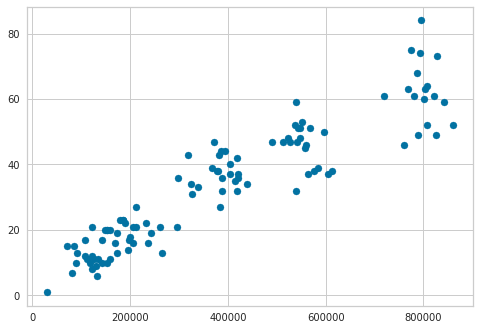

In [42]:
plt.scatter(X, y, marker='o');

In [43]:
from yellowbrick.regressor import ResidualsPlot

def show_residuals_plot(model, X_train, y_train, X_test, y_test):
    
    fig, ax = plt.subplots(figsize=(12, 8))
    rpv = ResidualsPlot(model, hist=True, qqplot=False)
    rpv.fit(X_train, y_train)
    rpv.score(X_test, y_test)
    rpv.poof()
    #fig.savefig("images/regression_metrics_residuals_plot.png", dpi=300)

In [44]:
from sklearn.linear_model import LinearRegression

model_hetero = LinearRegression(fit_intercept=True, n_jobs=-1)

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

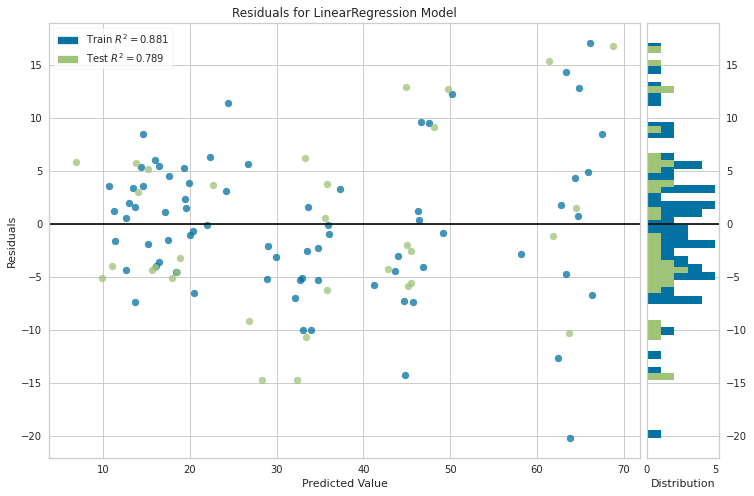

In [46]:
show_residuals_plot(model_hetero, X_train, y_train, X_test, y_test)

#### Redefining the variables
If your model is a cross-sectional model that includes large differences between the sizes of the observations, you can find different ways to specify the model that reduces the impact of the size differential. To do this, change the model from using the raw measure to using rates and per capita values. Of course, this type of model answers a slightly different kind of question. You’ll need to determine whether this approach is suitable for both your data and what you need to learn.

I prefer this method when it is appropriate because it involves the least amount of tinkering with the original data. You adjust only the specific variables that need to be changed in a manner that often makes sense. Indeed, this practice forces you to think about different ways to specify your model, which frequently improves it beyond just removing heteroscedasticity.

For our original model, we were using population to predict the number of accidents. If you think about it, it isn’t surprising that larger cities have more accidents. That’s not particularly enlightening.

However, we can change the model so that we use population to predict the accident rate. This approach discounts the impact of scale and gets to the underlying behavior. Let’s try this with our example data set. I’ll use Accident Rate as the dependent variable and Population as the independent variable. The residual plot is below.

In [49]:
y = df_hetero[['AccidentRate']]
X = df_hetero[['Population']]

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

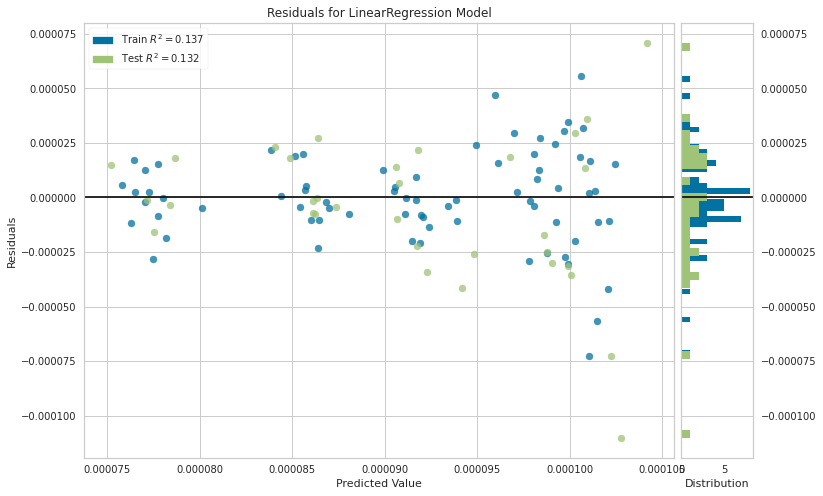

In [54]:
model_hetero = LinearRegression(fit_intercept=True, n_jobs=-1)
show_residuals_plot(model_hetero, X_train, y_train, X_test, y_test)

The residuals by fitted value plot looks better. If it weren’t for a few pesky values in the very high range, it would be useable. If this approach had produced homoscedasticity, I would stick with this solution and not use the following methods.

#### Weighted regression
`Weighted regression` is a method that assigns each data point a weight based on the variance of its fitted value. The idea is to give small weights to observations associated with higher variances to shrink their squared residuals. Weighted regression minimizes the sum of the weighted squared residuals. When you use the correct weights, heteroscedasticity is replaced by homoscedasticity.

I prefer this approach somewhat less than redefining the variables. For one thing, weighted regression involves more data manipulation because it applies the weights to all variables. It’s also less intuitive. And, if you skip straight to this, you might miss the opportunity to specify a more meaningful model by redefining the variables.

For our data, we know that higher populations are associated with higher variances. Consequently, we need to assign lower weights to observations of large populations. Finding the theoretically correct weight can be difficult. However, when you can identify a variable that is associated with the changing variance, a common approach is to use the inverse of that variable as the weight. In our case, the `Weight column in the dataset equals 1 / Population`.

I’ll go back to using Accidents as the dependent variable and Population as the independent variable. However, I’ll tell the software to perform weighted regression and apply the column of weights. The residual plot is below. For weighted regression, it is important to assess the standardized residuals because only that type of residual will show us that weighted regression fixed the heteroscedasticity.

In [55]:
y = df_hetero[['Accidents']]
X = df_hetero[['Population', 'Weight']]

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [65]:
X_train[['Weight']].values.ravel()

array([9.38360387e-06, 5.76260677e-06, 1.10793586e-05, 1.91329979e-06,
       1.73826271e-06, 2.37301432e-06, 1.12753564e-05, 8.26643343e-06,
       5.09542458e-06, 6.55778619e-06, 1.21262730e-06, 3.76757395e-06,
       1.23814680e-06, 2.62341831e-06, 8.46577868e-06, 8.95672457e-06,
       1.89502076e-06, 2.47375230e-06, 1.28215531e-06, 1.29075215e-06,
       6.30847098e-06, 2.58245838e-06, 9.29847569e-06, 1.76293064e-06,
       7.53643861e-06, 6.51432768e-06, 4.88163253e-06, 5.05522102e-06,
       1.81558840e-06, 1.78477461e-06, 5.95129668e-06, 4.99889452e-06,
       1.79046894e-06, 2.38105899e-06, 3.07823173e-06, 1.25941975e-06,
       2.71854585e-06, 6.34132280e-06, 2.53785524e-06, 2.65449641e-06,
       1.23915208e-06, 4.85737384e-06, 1.24415897e-05, 8.27054941e-06,
       1.21608396e-06, 2.47622812e-06, 1.85582028e-06, 1.18653682e-06,
       2.63231021e-06, 2.57576481e-06, 1.86032085e-06, 2.03661440e-06,
       1.24747835e-06, 3.82648009e-06, 4.22307562e-06, 1.27015445e-06,
      

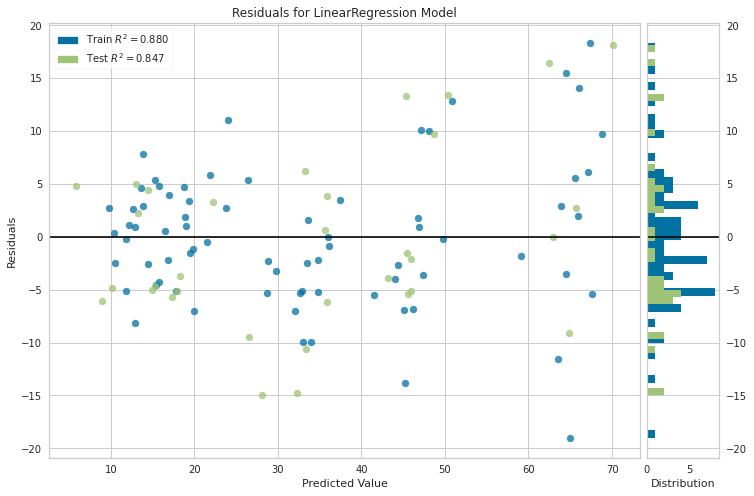

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [80]:
model_hetero = LinearRegression(fit_intercept=True, normalize=True, n_jobs=-1)

fig, ax = plt.subplots(figsize=(12, 8))
rpv = ResidualsPlot(model_hetero, hist=True, qqplot=False)
rpv.fit(X_train[['Population']], y_train, sample_weight=X_train[['Weight']].values.ravel())
rpv.score(X_test[['Population']], y_test, sample_weight=X_test[['Weight']].values.ravel())
rpv.poof()

In [82]:
import statsmodels.api as sm

mod_wls = sm.WLS(y_train, X_train[['Population']], weights=X_train[['Weight']].values.ravel())
res_wls = mod_wls.fit()
print(res_wls.summary())

                                 WLS Regression Results                                
Dep. Variable:              Accidents   R-squared (uncentered):                   0.958
Model:                            WLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                              1686.
Date:                Tue, 20 Apr 2021   Prob (F-statistic):                    3.46e-52
Time:                        12:51:22   Log-Likelihood:                         -241.08
No. Observations:                  74   AIC:                                      484.2
Df Residuals:                      73   BIC:                                      486.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [83]:
res_wls.resid

33      2.789312
68     -1.998325
101     5.199057
28      2.827022
40    -11.721742
         ...    
71      4.131206
14    -19.088013
92     -1.619421
51     -0.593969
102     2.823851
Length: 74, dtype: float64

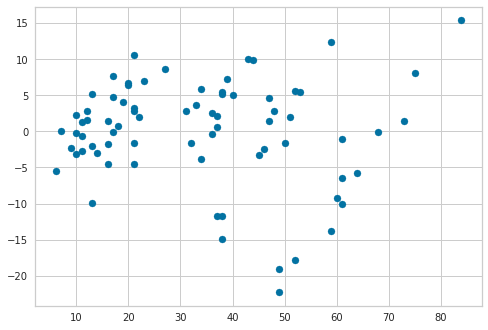

In [85]:
plt.scatter(y_train, res_wls.resid, marker='o');

As you can see, the data transformation didn’t produce homoscedasticity in this dataset (even though it is closer).

#### Transform the dependent variable
I always save transforming the data for the last resort because it involves the most manipulation. It also makes interpreting the results very difficult because the units of your data are gone. The idea is that you transform your original data into different values that produce good looking residuals. If nothing else works, try a transformation to produce homoscedasticity.

I’ll refit the original model but use a Box-Cox transformation on the dependent variable.

In [87]:
from scipy import stats

# transform training data & save lambda value
fitted_data, fitted_lambda = stats.boxcox(y_train.values.ravel())

In [88]:
mod_ols = sm.OLS(fitted_data, X_train[['Population']], weights=X_train[['Weight']].values.ravel())
res_ols = mod_ols.fit()
print(res_ols.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.913
Model:                            OLS   Adj. R-squared (uncentered):              0.912
Method:                 Least Squares   F-statistic:                              764.1
Date:                Tue, 20 Apr 2021   Prob (F-statistic):                    2.08e-40
Time:                        13:00:34   Log-Likelihood:                         -154.63
No. Observations:                  74   AIC:                                      311.3
Df Residuals:                      73   BIC:                                      313.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

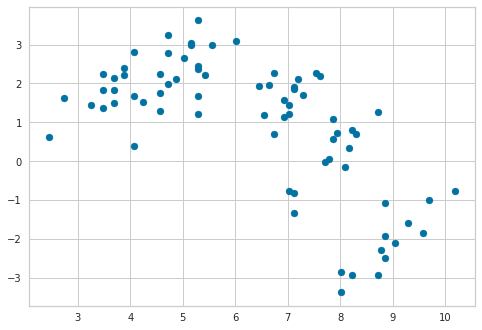

In [89]:
plt.scatter(fitted_data, res_ols.resid, marker='o');

As you can see, the data transformation didn’t produce homoscedasticity in this dataset.

Keep in mind that there are many different reasons for heteroscedasticity. Identifying the cause and resolving the problem in order to produce homoscedasticity can require extensive subject-area knowledge. In most cases, remedial actions for severe heteroscedasticity are necessary. However, `if your primary goal is to predict the total amount of the dependent variable rather than estimating the specific effects of the independent variables, you might not need to correct non-constant variance`.

The `statsmodel` library includes the **Breusch-Pagan test for heteroscedasticity**. This means that variance of the residuals varies over the predicted values. In the Breusch-Pagan test, if the p-values are significant (p-value less than 0.05), the null hypothesis of homoscedasticity is rejected. This indicates that residuals are `heteroscedastic`, and the predictions are biased.

In [30]:
import statsmodels.stats.api as sms

resids = (y_test.values.ravel() - rfr.predict(X_test))

hb = sms.het_breuschpagan(resids, X_test)
labels = [
    "Lagrange multiplier statistic",
    "p-value",
    "f-value",
    "f p-value",
]

for label, num in zip(labels, hb):
    print(f"{label}: {num:.2}")

Lagrange multiplier statistic: 3.8e+01
p-value: 0.00016
f-value: 3.5
f p-value: 8.6e-05


---
<a id='norm_res'></a>

## Normal Residuals
The `scipy` library includes a probability plot and the **Kolmogorov-Smirnov test**, both of which **measure whether the residuals are normal**.

### Histogram
We can plot a histogram to visualize the residuals and check for normality.

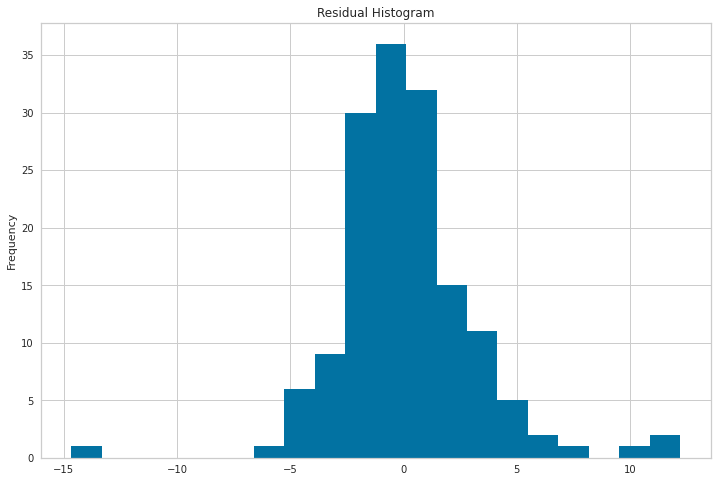

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))
resids = y_test.values.ravel() - rfr.predict(X_test)
pd.Series(resids, name="residuals").plot.hist(bins=20, ax=ax, title="Residual Histogram")
fig.savefig("images/regression_metrics_normal_residuals.png", dpi=300)

### Probability plot
If the samples plotted against the quantiles line up, the residuals are normal. We can see that this fails in this case.

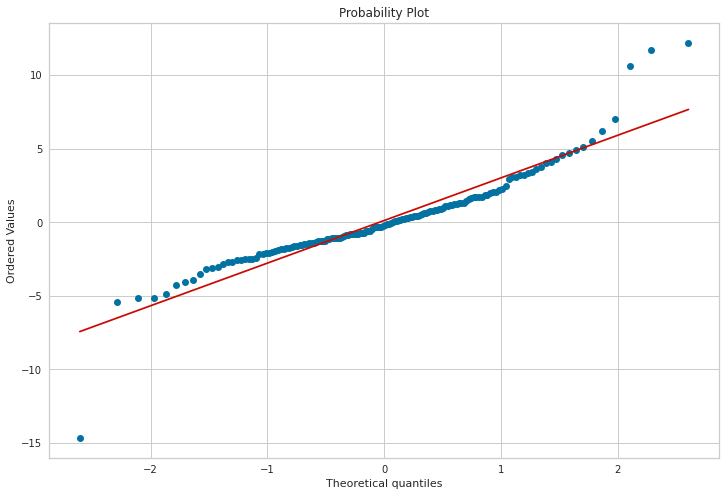

In [34]:
from scipy import stats

fig, ax = plt.subplots(figsize=(12, 8))
_ = stats.probplot(resids, plot=ax)
fig.savefig("images/regression_metrics_probability_plot.png", dpi=300)

The **Kolmogorov-Smirnov test can evaluate whether a distribution is normal**. If the p-value is significant (< 0.05), then the values are not normal.

This fails as well, which tells us the residuals are not normal.

In [35]:
stats.kstest(resids, cdf="norm")

KstestResult(statistic=0.2070667244097814, pvalue=3.410190989297583e-06)

---
<a id='pred_err'></a>

## Prediction Error Plot
A prediction error plot shows the real targets against the predicted values. For a perfect model these points would line up in a 45-degree line.

As our model seems to predict lower values for the high end of y, the model has some performance issues. This is also evident in the residuals plot.

In [19]:
y_test.values.ravel()

array([23.6, 32.4, 13.6, 22.8, 16.1, 20. , 17.8, 14. , 19.6, 16.8, 21.5,
       18.9,  7. , 21.2, 18.5, 29.8, 18.8, 10.2, 50. , 14.1, 25.2, 29.1,
       12.7, 22.4, 14.2, 13.8, 20.3, 14.9, 21.7, 18.3, 23.1, 23.8, 15. ,
       20.8, 19.1, 19.4, 34.7, 19.5, 24.4, 23.4, 19.7, 28.2, 50. , 17.4,
       22.6, 15.1, 13.1, 24.2, 19.9, 24. , 18.9, 35.4, 15.2, 26.5, 43.5,
       21.2, 18.4, 28.5, 23.9, 18.5, 25. , 35.4, 31.5, 20.2, 24.1, 20. ,
       13.1, 24.8, 30.8, 12.7, 20. , 23.7, 10.8, 20.6, 20.8,  5. , 20.1,
       48.5, 10.9,  7. , 20.9, 17.2, 20.9,  9.7, 19.4, 29. , 16.4, 25. ,
       25. , 17.1, 23.2, 10.4, 19.6, 17.2, 27.5, 23. , 50. , 17.9,  9.6,
       17.2, 22.5, 21.4, 12. , 19.9, 19.4, 13.4, 18.2, 24.6, 21.1, 24.7,
        8.7, 27.5, 20.7, 36.2, 31.6, 11.7, 39.8, 13.9, 21.8, 23.7, 17.6,
       24.4,  8.8, 19.2, 25.3, 20.4, 23.1, 37.9, 15.6, 45.4, 15.7, 22.6,
       14.5, 18.7, 17.8, 16.1, 20.6, 31.6, 29.1, 15.6, 17.5, 22.5, 19.4,
       19.3,  8.5, 20.6, 17. , 17.1, 14.5, 50. , 14

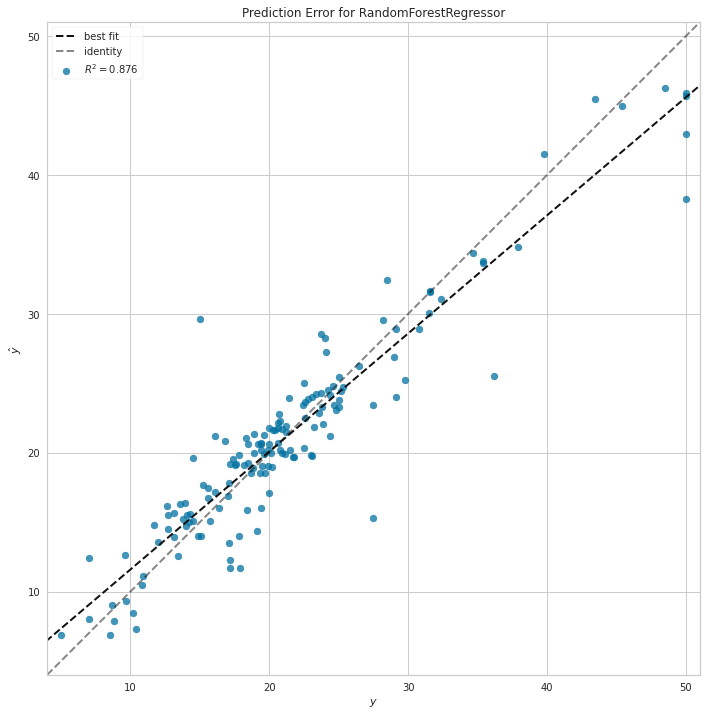

In [37]:
from yellowbrick.regressor import PredictionError

fig, ax = plt.subplots(figsize=(12, 12))
pev = PredictionError(rfr)
pev.fit(X_train, y_train.values.ravel())
pev.score(X_test, y_test.values.ravel())
pev.poof()
fig.savefig("images/regression_metrics_prediction_error_plot.png", dpi=300)